In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import scipy.stats as stats
pd.set_option('display.max_columns', None)

In [2]:
equity = pd.read_excel("data.xlsx", sheet_name="equity", engine='openpyxl')
print(equity.info())

equity.columns = [
    'date', 
    'SPX',      # S&P 500 Index
    'DM',       # MSCI World ex.USA Index
    'EM',       # MSCI Emerging Market Index
    'Growth',   # Russell 1000 Growth Index
    'Value',    # Russell 1000 Value Index
    'SmallCap', # Russell 2000 Index
    'COND',     # S&P 500 GICS Consumer Discretionary Sector Index
    'INDU',     # S&P 500 GICS Industrial Sector Index
    'FINL',     # S&P 500 GICS Financial Sector Index
    'CONS',     # S&P 500 GICS Consumer Staple Sector Index
    'HLTH',     # S&P 500 GICS Health Care Sector Index
    'UTIL',     # S&P 500 GICS Utility Sector Index
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8846 entries, 0 to 8845
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                8846 non-null   datetime64[ns]
 1   SPX Index  (R2)     8542 non-null   float64       
 2   MXWOU Index  (L1)   8845 non-null   float64       
 3   MXEF Index  (L1)    8845 non-null   float64       
 4   RLG Index  (R2)     8347 non-null   float64       
 5   RLV Index  (L1)     8348 non-null   float64       
 6   RTY Index  (R2)     8628 non-null   float64       
 7   S5COND Index  (L1)  8542 non-null   float64       
 8   S5INDU Index  (L1)  8542 non-null   float64       
 9   S5FINL Index  (R1)  8542 non-null   float64       
 10  S5CONS Index  (R1)  8542 non-null   float64       
 11  S5HLTH Index  (L1)  8542 non-null   float64       
 12  S5UTIL Index  (R1)  8542 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 

In [3]:
other_assets = pd.read_excel("data.xlsx", sheet_name="other_assets", engine='openpyxl')
print(other_assets.info())

other_assets.columns = [
    'date',
    'Treasuries',  # Bloomberg US Treasury Total Return Index
    'CorpIG',      # Bloomberg US Corporate Total Return Value
    'CorpHY',      # Bloomberg US Corporate High Yield Total Return Index
    'Commodities', # Bloomberg Commodity Total Return Index
    'REITs'        # FTSE NAREIT All Equity REITS Total Return Index
]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8643 entries, 0 to 8642
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  8643 non-null   datetime64[ns]
 1   LUATTRUU Index  (L1)  7495 non-null   float64       
 2   LUACTRUU Index  (L1)  8486 non-null   float64       
 3   LF98TRUU Index  (L1)  6435 non-null   float64       
 4   BCOMTR Index  (R1)    8511 non-null   float64       
 5   FNERTR Index  (R2)    6475 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 405.3 KB
None


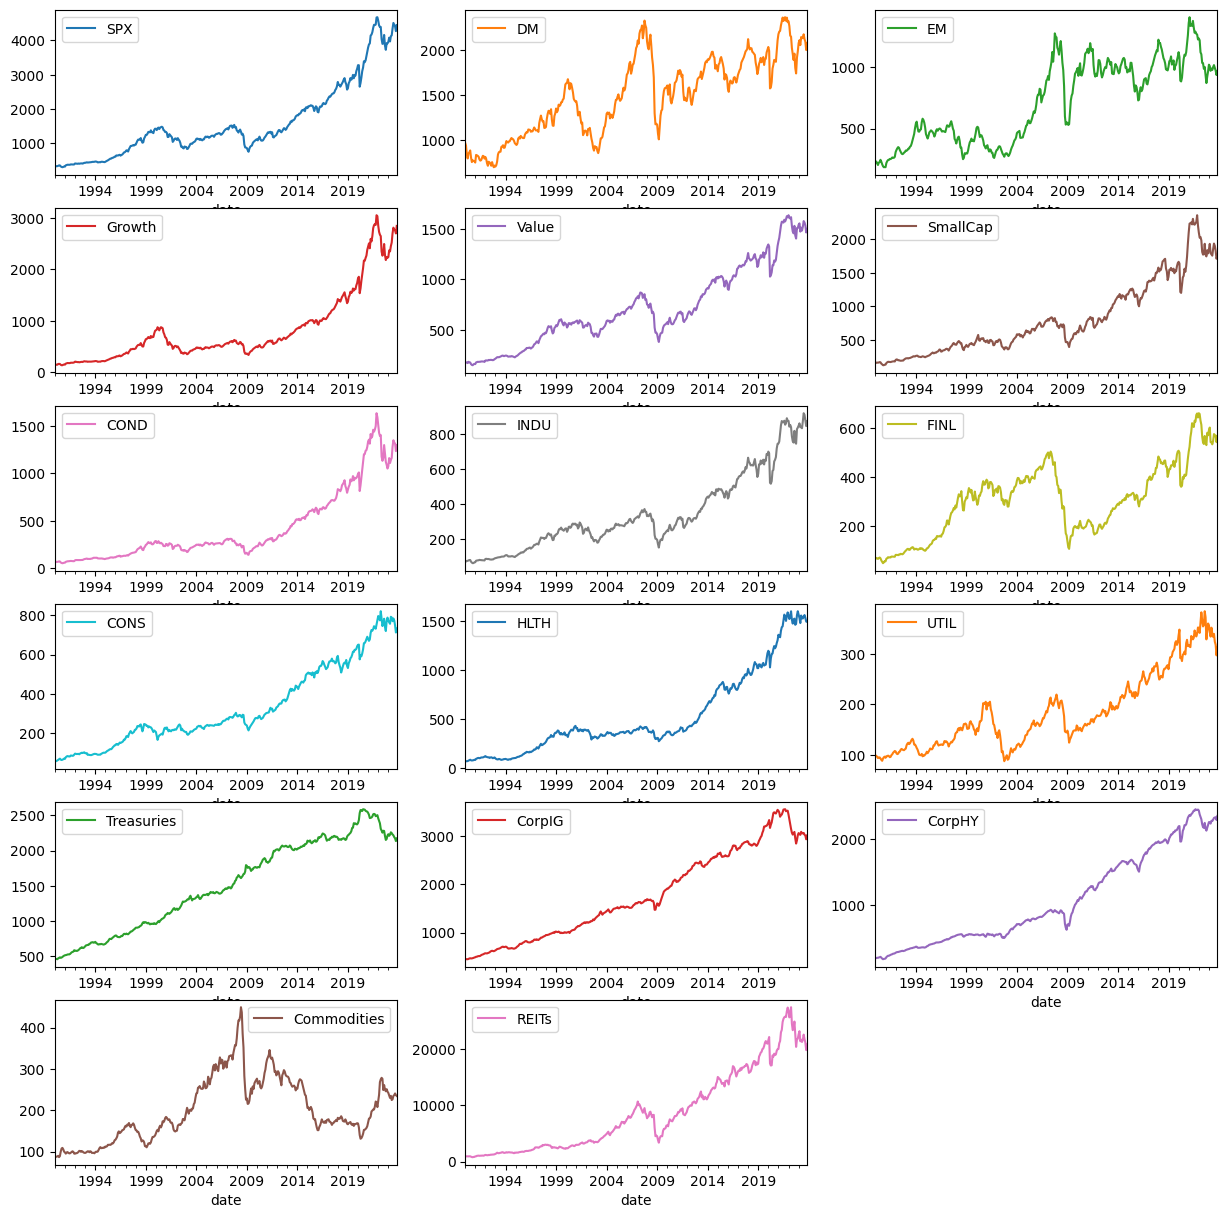

In [4]:
#first dataset: The Financial Dataset

asset = equity.merge(other_assets, on='date', how='outer')
asset.set_index('date',inplace=True)
asset = asset.resample('M').mean()
asset.plot(subplots=True, layout=(6, 3), figsize=(15, 15), sharex=False)
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 406 non-null    datetime64[ns]
 1   NAPMPMI Index  (L1)  406 non-null    float64       
 2   CPI YOY Index  (R1)  406 non-null    float64       
 3   FDTR Index  (R1)     406 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 12.8 KB
None


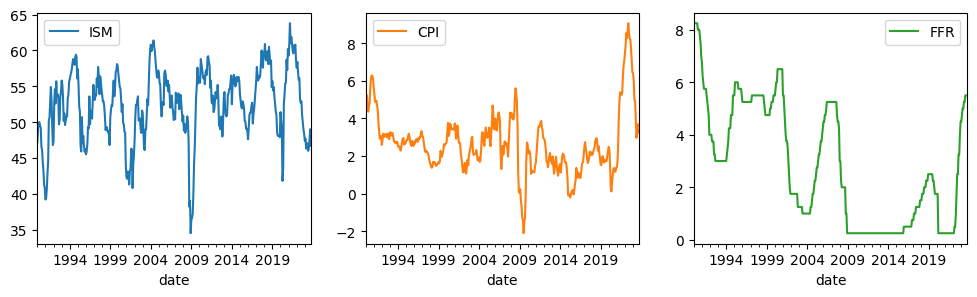

In [5]:
#second dataset: The Economic Dataset

econ = pd.read_excel("data.xlsx", sheet_name="economic", engine='openpyxl')
print(econ.info())
econ.columns = [
    'date',
    'ISM',  # US ISM Purchasing Managers Index
    'CPI',  # US Consumer Price Index YOY
    'FFR'   # Federal Funds Target Rate - Upper Bound
]
econ.set_index('date',inplace=True)

econ.plot(subplots=True, layout=(1, 3), figsize=(12, 3), sharex=False)
plt.show()

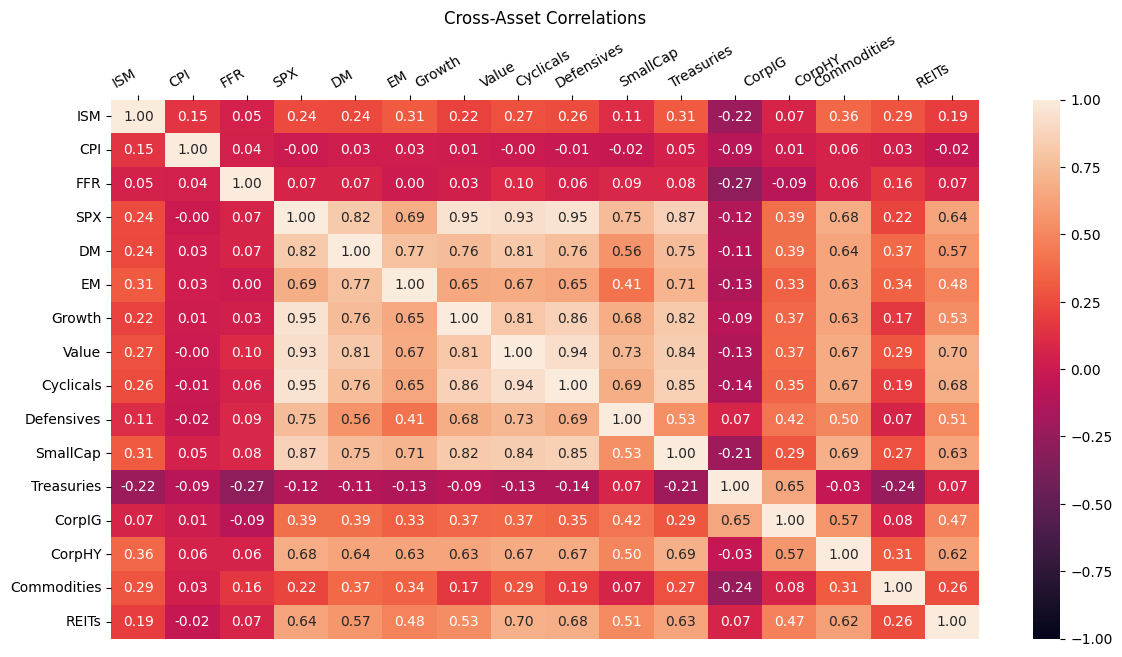

In [6]:
#create "Cyclical stock index" and "Defensive stock index"

econ_asset = pd.merge(econ, asset, left_index=True, right_index=True)
Cyclicals = econ_asset[['COND','INDU','FINL']]
Defensives = econ_asset[['CONS','HLTH','UTIL']]

Cyclicals_dict = {}
Defensives_dict = {}

for col in Cyclicals.columns:
    Cyclicals_dict[col] = (1+Cyclicals.pct_change()[col]).cumprod().fillna(1)

for col in Defensives.columns:
    Defensives_dict[col] = (1+Defensives.pct_change()[col]).cumprod().fillna(1)
    
econ_asset['Cyclicals'] = pd.DataFrame(Cyclicals_dict).sum(axis=1) / 3 * 100
econ_asset['Defensives'] = pd.DataFrame(Defensives_dict).sum(axis=1) / 3 * 100

econ_asset = econ_asset.drop((list(Cyclicals.columns)+list(Defensives.columns)),axis=1)
econ_asset.insert(8, 'Cyclicals', econ_asset.pop('Cyclicals'))
econ_asset.insert(9, 'Defensives', econ_asset.pop('Defensives'))

#correlation of assets and economics 

fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(econ_asset.pct_change().dropna().corr(), annot=True, fmt=".2f", vmax=1,vmin=-1)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
plt.xticks(rotation=30, ha='right')
plt.title('Cross-Asset Correlations')
plt.show()

In [7]:
#create a categotical variable of four stages of the economic cycle

econ_asset['ISM_above_50'] = econ_asset["ISM"].apply(lambda x: 1 if x>50 else 0)
econ_asset['CPI_above_2'] = econ_asset["CPI"].apply(lambda x: 1 if x>2 else 0)
econ_asset.insert(0, 'ISM_above_50', econ_asset.pop('ISM_above_50'))
econ_asset.insert(1, 'CPI_above_2', econ_asset.pop('CPI_above_2'))

conditions = [
    (econ_asset['ISM'] <= 50) & (econ_asset['CPI'] <= 2), # 1 Recession
    (econ_asset['ISM'] > 50) & (econ_asset['CPI'] <= 2),  # 2 Early-cycle
    (econ_asset['ISM'] > 50) & (econ_asset['CPI'] > 2),   # 3 Mid-cycle
    (econ_asset['ISM'] <= 50) & (econ_asset['CPI'] > 2)   # 4 Late-cycle
    
]

values = [1, 2, 3, 4]

econ_asset['Cycle'] = np.select(conditions, values, default=0)
econ_asset.insert(0, 'Cycle', econ_asset.pop('Cycle'))
econ_asset.head()

,Cycle,ISM_above_50,CPI_above_2,ISM,CPI,FFR,SPX,DM,EM,Growth,Value,Cyclicals,Defensives,SmallCap,Treasuries,CorpIG,CorpHY,Commodities,REITs
date,,,,,,,,,,,,,,,,,,,
1990-01-31,4,0,1,47.2,5.20,8.25,339.971818,974.221304,224.601739,142.824,172.80,100.000000,100.000000,163.303864,460.81,450.215000,194.21,86.604232,950.14
1990-02-28,4,0,1,49.1,5.26,8.25,330.452632,943.063500,231.832000,143.430,176.19,96.515287,96.718742,157.659000,461.62,448.824211,190.20,87.324921,943.47
1990-03-31,4,0,1,49.9,5.23,8.25,338.465000,845.453182,218.024091,148.843,177.49,99.761824,96.748903,162.410000,461.47,449.724545,195.19,88.291759,952.88
1990-04-30,4,0,1,50.0,4.71,8.25,338.178000,800.286190,203.751905,146.682,170.13,98.706881,98.188341,161.072857,457.23,448.758500,194.86,88.661075,936.32
1990-05-31,4,0,1,49.5,4.36,8.25,350.250000,855.921304,222.262174,161.482,183.19,101.971545,102.321407,164.276565,470.09,453.925909,198.62,89.960586,935.60


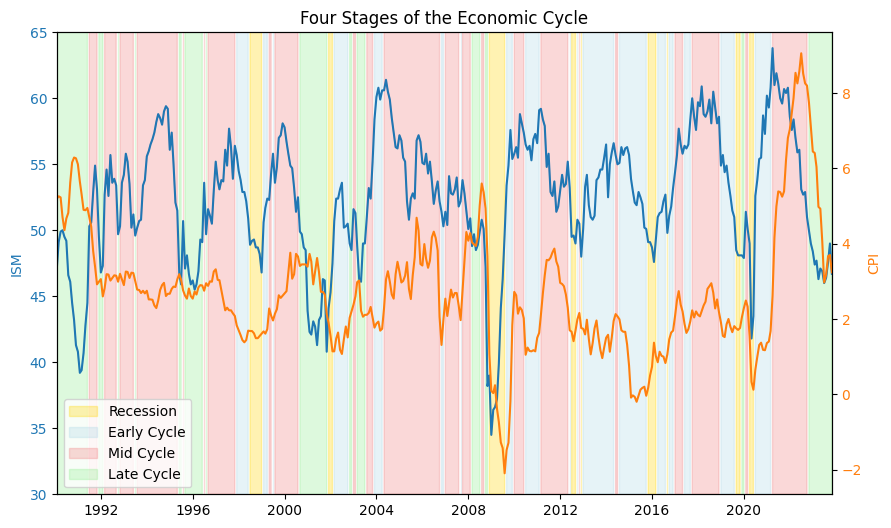

In [8]:
#Economic time series shaded with background color of different stages of the econoimc cycle  

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1_color = 'tab:blue'
ax1.plot(econ_asset.index, econ_asset['ISM'],color=ax1_color)
ax1.set_ylabel('ISM', color=ax1_color)
ax1.tick_params(axis='y', labelcolor=ax1_color)

ax2 = ax1.twinx()
ax2_color = 'tab:orange'
ax2.plot(econ_asset.index, econ_asset['CPI'],color=ax2_color)
ax2.set_ylabel('CPI', color=ax2_color)
ax2.tick_params(axis='y', labelcolor=ax2_color)

cycle_colors = {1: 'gold', 2: 'lightblue', 3: 'lightcoral', 4: 'lightgreen'}
for cycle_value, color in cycle_colors.items():
    cycle_periods = np.ma.masked_where(econ_asset['Cycle'] != cycle_value, econ_asset['ISM'])
    ax1.fill_between(econ_asset.index, cycle_periods, y2=30, color=color, alpha=0.3, label=f'cycle {cycle_value}')
    ax1.fill_between(econ_asset.index, cycle_periods, y2=65, color=color, alpha=0.3)    

ax1.set_title('Four Stages of the Economic Cycle')
ax1.set_xlim(econ_asset.index.min(), econ_asset.index.max())
ax1.set_ylim(30, 65)

L = ax1.legend()
L.get_texts()[0].set_text('Recession')
L.get_texts()[1].set_text('Early Cycle')
L.get_texts()[2].set_text('Mid Cycle')
L.get_texts()[3].set_text('Late Cycle')

plt.show()

four_cycle = ['Recession', 'Early Cycle', 'Mid Cycle', 'Late Cycle']

In [9]:
four_cycle = ['Recession', 'Early Cycle', 'Mid Cycle', 'Late Cycle']

print('Frequency of Four Cycles')
for name, number in zip(four_cycle, range(4)):
    print('•',name, ':', list(econ_asset['Cycle'].value_counts(normalize=True).sort_index().mul(100).round(1).astype(str) + '%')[number])

Frequency of Four Cycles
• Recession : 8.6%
• Early Cycle : 25.1%
• Mid Cycle : 46.8%
• Late Cycle : 19.5%


In [10]:
#create a function to calculate asset return, volatility and sharpe ratio

df = econ_asset.drop(['ISM_above_50','CPI_above_2','ISM','CPI','FFR'], axis=1)
df.iloc[:,1:] = df.iloc[:,1:].pct_change()
df = df.dropna()

def risk_return_profile(df, risk_free_rate=econ_asset['FFR'].mean()/100):
    df = df.iloc[:, 1:]
    ann_return = (1 + df.mean()) ** 12 - 1 #annualized return
    ann_volatility = df.std()* (12**0.5)   #annualized standard deviation
    ann_sharp = (ann_return - risk_free_rate) / ann_volatility
    
    risk_return_metrics = pd.DataFrame({
        'Return': ann_return.round(4)*100,
        'Volatility': ann_volatility.round(4)*100,
        'Sharpe': ann_sharp.round(2)
    })
    
    return risk_return_metrics

df_sum = risk_return_profile(df)
df_sum

,Return,Volatility,Sharpe
SPX,8.63,12.35,0.47
DM,3.19,14.03,0.03
EM,6.24,18.98,0.18
Growth,10.21,14.15,0.52
Value,7.41,12.64,0.36
Cyclicals,9.03,15.40,0.40
Defensives,8.23,10.19,0.53
SmallCap,8.80,16.96,0.35
Treasuries,4.73,3.96,0.48
CorpIG,5.83,4.85,0.62


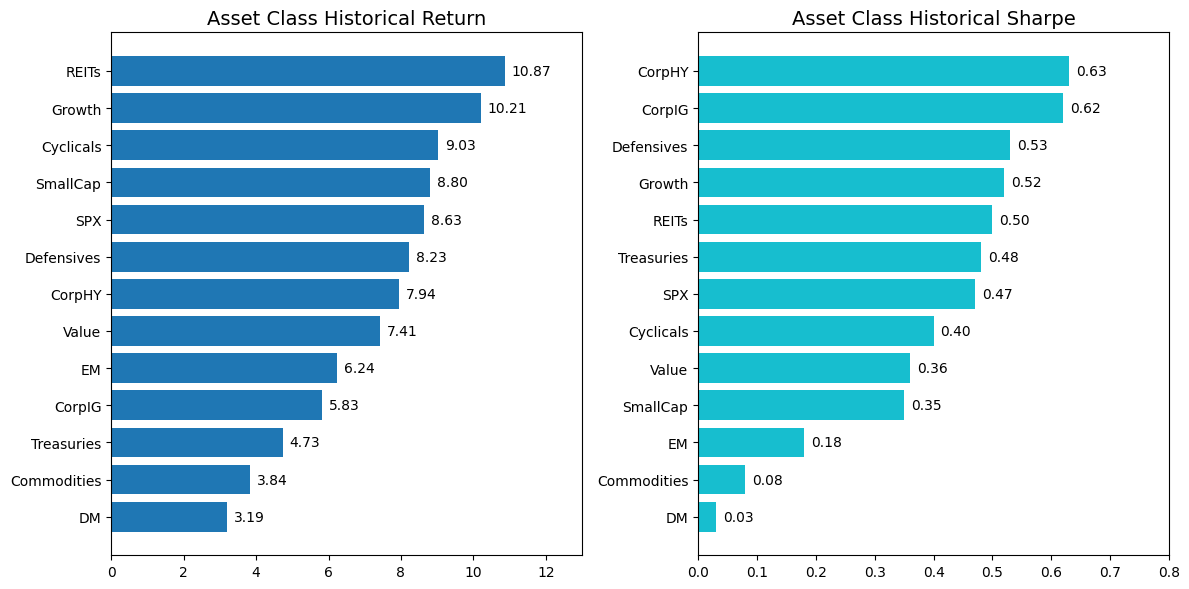

In [11]:
#asset performance across economic cycles

fig, axs = plt.subplots(1, 2, figsize=(12, 6)) 
data_col = ["Return", "Sharpe"]
colors = ['tab:blue', 'tab:cyan']
x_lim = [13,0.8]

for col, ax, color, xlim in zip(data_col, axs.ravel(), colors, x_lim):
    data = df_sum[col].sort_values()
    ax.barh(data.index, data, color=color)
    ax.bar_label(ax.containers[0],fmt='%.2f', fontsize=10, padding=5)
    ax.set_xlim(0,xlim)
    ax.set_title("Asset Class Historical " + col, fontsize=14)

plt.tight_layout()
plt.show()

In [12]:
#highlight the best-performaning economic stage for each asset
#ANOVA analysis shows that there exists a significant difference in the return/volatility/sharpe among four cycle    

df_cycle = df.groupby('Cycle').apply(risk_return_profile).unstack()

df_cycle_dict = {}
df_sum_dict = {}

for metric in ['Return', 'Volatility', 'Sharpe']:
    df_cycle_dict[metric] = df_cycle[metric]
    df_sum_dict[metric] = pd.DataFrame(df_sum[metric]).transpose()
    df_cycle_dict[metric] = pd.concat([df_cycle_dict[metric], df_sum_dict[metric]])
    df_cycle_dict[metric].rename(index={metric:'sum'}, inplace=True)
    
def highlight_max(series, max_or_min):
    if max_or_min == "max":
        col_max = series == series.max()
        styles = ['background-color: gainsboro; font-weight: bold' if i else '' for i in col_max]
        return styles
    elif max_or_min == "min":
        col_min = series == series.min()
        styles = ['background-color: gainsboro; font-weight: bold' if i else '' for i in col_min]
        return styles
    
for data, max_min, title, anova in zip(df_cycle_dict.keys(), ['max','min','max'], df_cycle_dict.keys(), df_cycle_dict.keys()):
    display(df_cycle_dict[data].style.apply(highlight_max, max_or_min=max_min).set_caption(title))
    print(stats.f_oneway(df_cycle_dict[data].loc[1], df_cycle_dict[data].loc[2], df_cycle_dict[data].loc[3], df_cycle_dict[data].loc[4]))

,SPX,DM,EM,Growth,Value,Cyclicals,Defensives,SmallCap,Treasuries,CorpIG,CorpHY,Commodities,REITs
1,1.340000,-4.030000,2.520000,9.170000,-7.110000,-4.200000,1.710000,-9.570000,7.970000,10.760000,6.790000,-21.380000,-12.250000
2,14.920000,11.490000,11.110000,16.670000,14.280000,19.350000,11.440000,17.510000,3.850000,7.010000,10.630000,6.370000,16.970000
3,9.340000,4.710000,9.130000,10.380000,8.380000,8.760000,7.840000,10.220000,3.500000,3.950000,7.600000,8.160000,14.240000
4,2.420000,-7.110000,-4.690000,2.300000,3.380000,3.170000,8.080000,3.440000,7.510000,6.770000,5.810000,3.070000,6.620000
sum,8.630000,3.190000,6.240000,10.210000,7.410000,9.030000,8.230000,8.800000,4.730000,5.830000,7.940000,3.840000,10.870000


F_onewayResult(statistic=13.337577376941528, pvalue=1.8571791899639618e-06)


,SPX,DM,EM,Growth,Value,Cyclicals,Defensives,SmallCap,Treasuries,CorpIG,CorpHY,Commodities,REITs
1,20.120000,21.770000,28.900000,20.570000,21.760000,27.370000,13.740000,27.480000,5.410000,6.450000,15.550000,16.750000,28.690000
2,10.520000,11.900000,15.700000,11.260000,10.940000,12.190000,8.920000,14.660000,3.120000,3.850000,5.770000,11.140000,12.860000
3,9.500000,11.450000,16.420000,11.430000,9.510000,11.560000,9.010000,13.500000,3.900000,4.400000,4.990000,11.210000,13.340000
4,15.710000,17.240000,22.840000,19.200000,15.360000,19.280000,12.470000,20.600000,4.270000,6.050000,11.550000,14.010000,17.540000
sum,12.350000,14.030000,18.980000,14.150000,12.640000,15.400000,10.190000,16.960000,3.960000,4.850000,8.120000,12.530000,16.050000


F_onewayResult(statistic=9.004514655308277, pvalue=7.737702124138024e-05)


,SPX,DM,EM,Growth,Value,Cyclicals,Defensives,SmallCap,Treasuries,CorpIG,CorpHY,Commodities,REITs
1,-0.070000,-0.310000,-0.010000,0.310000,-0.460000,-0.260000,-0.080000,-0.450000,0.950000,1.230000,0.260000,-1.440000,-0.530000
2,1.150000,0.730000,0.530000,1.230000,1.050000,1.360000,0.970000,1.000000,0.330000,1.090000,1.360000,0.320000,1.100000
3,0.690000,0.170000,0.380000,0.660000,0.590000,0.510000,0.560000,0.550000,0.180000,0.260000,0.960000,0.480000,0.860000
4,-0.030000,-0.580000,-0.330000,-0.030000,0.040000,0.020000,0.420000,0.030000,1.100000,0.650000,0.260000,0.020000,0.220000
sum,0.470000,0.030000,0.180000,0.520000,0.360000,0.400000,0.530000,0.350000,0.480000,0.620000,0.630000,0.080000,0.500000


F_onewayResult(statistic=12.582519151073722, pvalue=3.4214878911090385e-06)


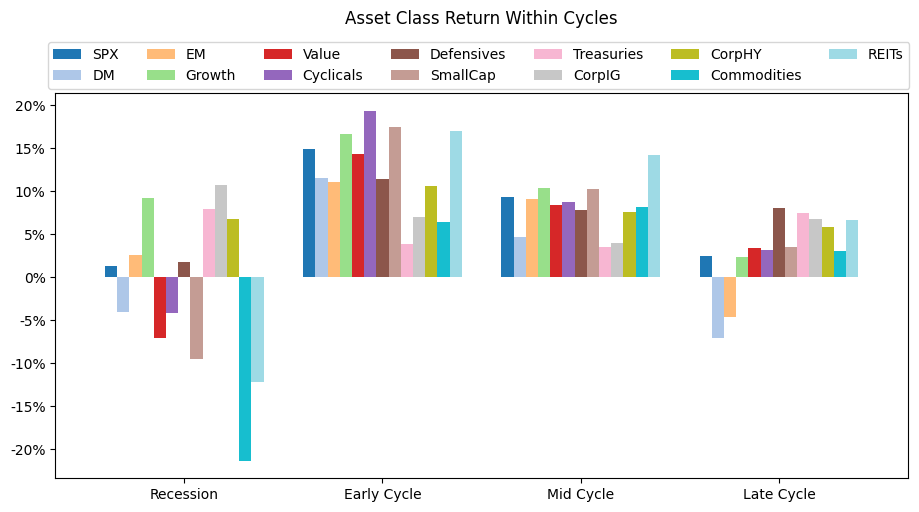

In [13]:
#performance of different assets within economic cycles

ax = df_cycle_dict['Return'].iloc[0:4].plot.bar(figsize=(11, 5), width=0.8, colormap='tab20')

ax.set_xticklabels(["Recession", "Early Cycle", "Mid Cycle", "Late Cycle"], rotation=0)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}%'))
plt.xlabel(None)
plt.legend(df_cycle_dict['Return'].iloc[0:4].columns, bbox_to_anchor=(0.51, 1.15, 0.5, 0), ncol=7)
plt.title('Asset Class Return Within Cycles', pad=50)
plt.show()

In [14]:
#build a "Cycle-Adjusted Portfolio" which dynamically adjusts the allocation based on the economic cycle
#aiming to compare its performance to an "Equal-Weighted Portfolio" (100% / 13 assets = 7.69% each)
#"Cycle-Adjusted Portfolio": double the weights (15.38%) of the top 5 performaning assets and reduce the bottom 5 to 0%

df_portfolio = df.copy() 

#Equal-Weighted Portfolio
equal_weight = 1/len(df_cycle['Return'].columns)
equal_weight_portfolio = {key: equal_weight for key in df_cycle['Return'].columns}
equal_weight_portfolio_return = df_portfolio.drop('Cycle',axis=1).apply(lambda row: sum(row[col]*equal_weight_portfolio[col] for col in df_portfolio.drop('Cycle',axis=1).columns), axis=1)
df_portfolio.insert(0, 'Equal-Weighted Portfolio', equal_weight_portfolio_return.round(4))

#Cycle-Adjusted Portfolio
higher_weight_assets, lower_weight_assets, same_weight_assets = {}, {}, {}
cycle_adjusted_portfolio, reordered_cycle_adjusted_portfolio, cycles_adjusted_portfolio_return = {}, {}, {}

for cycle, num in zip(four_cycle, range(1,5)):
    higher_weight_assets[cycle] = list(df_cycle['Return'].loc[num].nlargest(5).index)
    lower_weight_assets[cycle] = list(df_cycle['Return'].loc[num].nsmallest(5).index)
    same_weight_assets[cycle] = [asset for asset in df_cycle['Return'].columns if asset not in higher_weight_assets[cycle]+lower_weight_assets[cycle]]
    
    higher_weights = [equal_weight+equal_weight]*5
    lower_weights = [equal_weight-equal_weight]*5
    same_weights = [equal_weight]*3
    
    cycle_adjusted_portfolio[cycle] = dict(zip(higher_weight_assets[cycle]+lower_weight_assets[cycle]+same_weight_assets[cycle], higher_weights+lower_weights+same_weights))
    reordered_cycle_adjusted_portfolio[cycle] = list({key: cycle_adjusted_portfolio[cycle][key] for key in df_cycle['Return'].columns}.values())
    cycles_adjusted_portfolio_return[cycle] = df_portfolio[df_portfolio["Cycle"]==num].iloc[0:,2:].mul(reordered_cycle_adjusted_portfolio[cycle]).sum(axis=1)

cycle_adjusted_portfolio_return = pd.concat([cycles_adjusted_portfolio_return['Recession'], cycles_adjusted_portfolio_return['Early Cycle'], cycles_adjusted_portfolio_return['Mid Cycle'], cycles_adjusted_portfolio_return['Late Cycle']], axis=0).sort_index()
df_portfolio.insert(0, 'Cycle-Adjusted Portfolio', cycle_adjusted_portfolio_return.round(4))

def format_percentages(data):
    return [str(round(value * 100, 2)) + '%' for value in data]

df_portfolio_return = pd.DataFrame(columns=df_cycle['Return'].columns)
df_portfolio_return.loc['Equal-Weighted Portfolio'] = format_percentages(equal_weight_portfolio.values())

for cycle in four_cycle:
    df_portfolio_return.loc[cycle+' Portfolio Weights'] = format_percentages(reordered_cycle_adjusted_portfolio[cycle])

print("Weights of Equal-Weighted Portfolio and Cycle-Adjusted Portfolio")
display(df_portfolio_return)

Weights of Equal-Weighted Portfolio and Cycle-Adjusted Portfolio


,SPX,DM,EM,Growth,Value,Cyclicals,Defensives,SmallCap,Treasuries,CorpIG,CorpHY,Commodities,REITs
Equal-Weighted Portfolio,7.69%,7.69%,7.69%,7.69%,7.69%,7.69%,7.69%,7.69%,7.69%,7.69%,7.69%,7.69%,7.69%
Recession Portfolio Weights,7.69%,7.69%,15.38%,15.38%,0.0%,0.0%,7.69%,0.0%,15.38%,15.38%,15.38%,0.0%,0.0%
Early Cycle Portfolio Weights,15.38%,7.69%,0.0%,15.38%,7.69%,15.38%,7.69%,15.38%,0.0%,0.0%,0.0%,0.0%,15.38%
Mid Cycle Portfolio Weights,15.38%,0.0%,15.38%,15.38%,7.69%,7.69%,0.0%,15.38%,0.0%,0.0%,0.0%,7.69%,15.38%
Late Cycle Portfolio Weights,0.0%,0.0%,0.0%,0.0%,7.69%,7.69%,15.38%,7.69%,15.38%,15.38%,15.38%,0.0%,15.38%


Equal-Weighted Portfolio Average Annualized Return: 7.28%
Cycle-Adjusted Portfolio Average Annualized Return: 10.38%


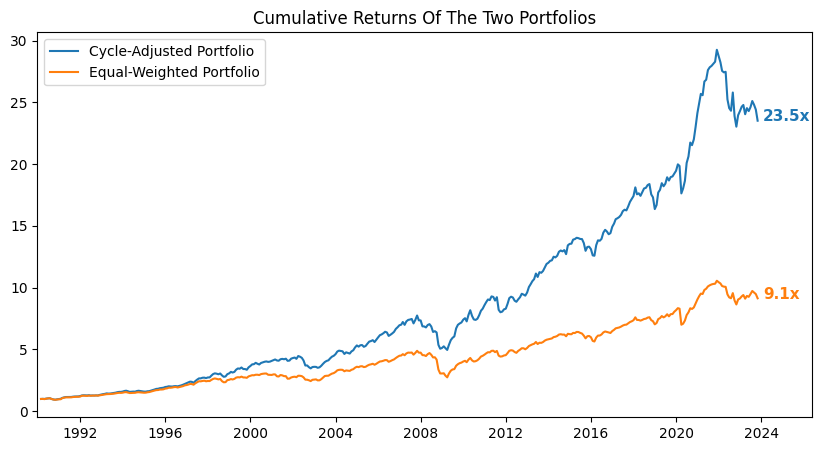

In [15]:
#result: "Cycle-Adjusted Portfolio" generated an annualized return of 10.38% vs. 7.28% of "Equal-Weighted Portfolio"
#Invested $1 in Jan 1990, you would get $23.5 by adopting this strategy instead of $9.1 of an equal-weighted portfolio

cycle_adjusted_portfolio_cumulative_returns = (1+df_portfolio['Cycle-Adjusted Portfolio']).cumprod()
equal_weighted_portfolio_cumulative_returns = (1+df_portfolio['Equal-Weighted Portfolio']).cumprod()
cycle_adjusted_portfolio_data_point = str((1+df_portfolio['Cycle-Adjusted Portfolio']).cumprod().iloc[-1].round(1))+'x'
equal_weighted_portfolio_data_point = str((1+df_portfolio['Equal-Weighted Portfolio']).cumprod().iloc[-1].round(1))+'x'

fig, ax = plt.subplots(figsize=(10,5))
plt.plot(cycle_adjusted_portfolio_cumulative_returns, label='Cycle-Adjusted Portfolio')
plt.plot(equal_weighted_portfolio_cumulative_returns,label='Equal-Weighted Portfolio')
plt.text(19750, 23.5, cycle_adjusted_portfolio_data_point, color='tab:blue', fontsize=11, weight='bold')
plt.text(19750, 9.1, equal_weighted_portfolio_data_point, color='tab:orange', fontsize=11, weight='bold')
plt.legend()
plt.xlim(7300,20600)
plt.title('Cumulative Returns Of The Two Portfolios')

print("Equal-Weighted Portfolio Average Annualized Return: ",round((1 + df_portfolio['Equal-Weighted Portfolio'].mean()) ** 12 - 1, 4)*100,'%',sep='')
print("Cycle-Adjusted Portfolio Average Annualized Return: ",round((1 + df_portfolio['Cycle-Adjusted Portfolio'].mean()) ** 12 - 1, 4)*100,'%',sep='')